## Notebook to compare final results MELD graph vs MELD per vertex
Results on test cohort and independant sites

In [1]:
#imports
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('/home/co-ripa1/rds/hpc-work/scripts/meld_classifier')
from meld_classifier.meld_cohort import MeldSubject,MeldCohort
from meld_graph.training import tp_fp_fn_tn, dice_coeff
from meld_graph.icospheres import IcoSpheres
from meld_graph.graph_tools import GraphTools
import itertools
import pandas as pd
from meld_graph.evaluation import load_prediction
from meld_graph import experiment

Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350


## Compare results MLP and Graph model

In [2]:

def df_stats(df, metrics=['sensitivity','specificity', 'ppv', 'IOU', 'IOU+']):
    metric_results = []
    for metric in metrics:
        if metric == 'sensitivity':
            sensitivity = np.mean(df['detected'][df['group']])
            metric_results.append(round(sensitivity,2))
        elif metric == 'specificity':
            specificity = (df['number FP clusters'][df['group']==False]==0).mean()
            metric_results.append(round(specificity,2))
        elif metric == 'ppv':
            total_detected = np.sum(df['number TP clusters'][df['group']])
            total_predicted = np.sum(df['number FP clusters'][df['group']])
            ppv = total_detected / (total_predicted + total_detected)
            metric_results.append(round(ppv,2))
        elif metric == 'IOU':
            iou = np.mean(df[(df['group'])&(df['detected'])]['IOU'])
            metric_results.append(round(iou,2))
        elif metric == 'IOU+':
            iou_plus = np.mean(df[(df['group'])&(df['detected'])]['IOU_plus'])
            metric_results.append(round(iou_plus,2))
        else:
            print(f'Metric {metric} does not exist')
            pass
    return metric_results

# bootstrapped confidence intervals
def bootstrap_CI(df, n=10000, func=df_stats):
    """Calculate confidence intervals for a given function"""
    bootstrapped = []
    for i in range(n):
        bootstrapped.append(func(df.sample(len(df), replace=True)))
    return np.percentile(np.array(bootstrapped), [2.5, 97.5],axis=0)

def get_pvalue(stat, distribution):
    p_pos = np.mean(distribution > stat)
    p_neg = np.mean(distribution < stat)
    p = min(p_pos,p_neg)*2
    return p

### load per-vertex results

In [3]:
def load_cohort_mlp(dataset):
    # Load the MELD cohort
    if dataset == 'test':
        ref = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/results'
        with h5py.File(os.path.join(ref, 'predictions_ensemble_iteration.hdf5'), "r") as f:
            subjects = list(f.keys())
        subjects.remove('MELD_H4_3T_FCD_0011') # because does not exist in graph model
        cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
                dataset='MELD_dataset_V6.csv')
    elif dataset == 'indi_test':
        refh27h28 = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/predict_NewSiteH27H28_21-09-20/fold_all/results'
        refh101 = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/predict_NewSiteH101_24-02-20/results'
        with h5py.File(os.path.join(refh27h28, 'predictions_ensemble_iteration.hdf5'), "r") as f:
            subjects = list(f.keys())
        with h5py.File(os.path.join(refh101, 'predictions_ensemble_iteration.hdf5'), "r") as f:
            subjects = subjects + list(f.keys())
        cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6_kernels_robustCombat_NewSite.hdf5', dataset='MELD_dataset_NewSiteH27H28H101.csv')
    else:
        raise ValueError('Unknown dataset')
    return cohort, subjects

In [4]:
#dataset one of ['test','indi_test']
dataset = 'indi_test'

#for H101 boundaries
cohort2= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_fastsurfer_harmonised_NewSite.hdf5', 
                           dataset='MELD_dataset_NewSiteH27H28H101_nc.csv')

cohort, subjects =  load_cohort_mlp(dataset)
refh27h28 = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/predict_NewSiteH27H28_21-09-20/fold_all/results'
refh101 = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/predict_NewSiteH101_24-02-20/results'
ref = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/results'


In [5]:
#load the predictions
df_mlp=pd.DataFrame()
subjects_dictionary={}
#values becomes each row of the dataframe

for si,subj in enumerate(subjects):
    values={}
    if si%100==0:
        print(si)
    values['ID']=subj
    #load the subject
    if "H101" in subj:
        s = MeldSubject(subj,cohort=cohort2)
    else:
        s = MeldSubject(subj,cohort=cohort)
    #add the group
    values['group']= True if s.group=='patient' else False
    labels_hemis = {}
    dists={}
    labels = np.zeros(len(cohort.cortex_label)*2)
    #load the borderzone
    for hemi in ['lh','rh']:
        dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                )
        if np.sum(dists[hemi])==0:
            dists[hemi] +=200
    labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
    borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
    #load pred from old classifier
    if 'H101' in subj:
        pred_file_old = os.path.join(refh101, 'predictions_ensemble_iteration.hdf5')
    elif ('H27' in subj) or ('H28' in subj):
        pred_file_old = os.path.join(refh27h28, 'predictions_ensemble_iteration.hdf5')
    else:
        pred_file_old = os.path.join(ref, 'predictions_ensemble_iteration.hdf5')

    result_hemis_old = load_prediction(subj,pred_file_old, dset='prediction')
    result_old = np.hstack([result_hemis_old['lh'],result_hemis_old['rh']])
    values['model']='per vertex'
    
    #add detection with borderzone
    if labels.sum()>0:
        values['detected'] = np.logical_and(result_old, borderzones).any()
        # add number of TP clusters - number of clusters that are in the borderzone
        clusters_in_borderzone = set(result_old[borderzones.astype('bool')])
        #remove the 0 cluster
        if 0 in clusters_in_borderzone:
            clusters_in_borderzone.remove(0)
        values['number TP clusters'] = len(clusters_in_borderzone)
        values['size_pred'] = len(result_old[borderzones.astype('bool')])
        values['IOU'] = (np.logical_and(result_old, labels)).sum() / (np.logical_or(result_old, labels)).sum()
        values['IOU_plus'] = (np.logical_and(result_old, borderzones)).sum() / (np.logical_or(result_old, borderzones)).sum()
    else:
        values['number TP clusters'] = 0
        values['size_pred'] = np.nan
        values['IOU'] = np.nan
        values['IOU_plus'] = np.nan
    # add number of FP clusters : total clusters - TP clusters
    values['number FP clusters']=len(set(result_hemis_old['lh']))+len(set(result_hemis_old['rh']))-2-values['number TP clusters']
    df_mlp=pd.concat([df_mlp,pd.DataFrame([values])])
df_mlp = df_mlp.reset_index()
df_mlp.head()

0
100
200


,index,ID,group,model,number TP clusters,size_pred,IOU,IOU_plus,number FP clusters,detected
0,0,MELD_H27_3T_C_0018,False,per vertex,0,NaN,NaN,NaN,1,NaN
1,0,MELD_H27_3T_C_0019,False,per vertex,0,NaN,NaN,NaN,1,NaN
2,0,MELD_H27_3T_C_0020,False,per vertex,0,NaN,NaN,NaN,0,NaN
3,0,MELD_H27_3T_C_0021,False,per vertex,0,NaN,NaN,NaN,5,NaN
4,0,MELD_H27_3T_C_0022,False,per vertex,0,NaN,NaN,NaN,0,NaN


In [6]:
# results MLP model
print('all together')
dfsub = df_mlp.copy()
# dfsub_mlp = dfsub.copy()
print(len(dfsub))
sensitivity_mlp, specificity_mlp, ppv_mlp, iou_mlp, iou_plus_mlp = df_stats(dfsub)
print('sensitivity specificity ppv iou iou+')
print(sensitivity_mlp,specificity_mlp, ppv_mlp, iou_mlp, iou_plus_mlp)
CI_mlp = bootstrap_CI(dfsub)
print(CI_mlp)

if dataset=='indi_test':
    try:
        for site in ['H27', 'H28', 'H101']:
            print(site)
            dfsub = df_mlp[df_mlp['ID'].str.contains(site)]
            sensitivity, specificity, ppv, iou, iou_plus = df_stats(dfsub)
            print('sensitivity specificity ppv iou iou+')
            print(sensitivity,specificity,ppv, iou, iou_plus)
    except:
        pass

all together
217
sensitivity specificity ppv iou iou+
0.77 0.47 0.46 0.27 0.08
[[0.69 0.37 0.4  0.23 0.07]
 [0.84 0.56 0.53 0.3  0.1 ]]
H27
sensitivity specificity ppv iou iou+
0.94 0.17 0.52 0.3 0.13
H28
sensitivity specificity ppv iou iou+
0.62 nan 0.32 0.19 0.07
H101
sensitivity specificity ppv iou iou+
0.76 0.53 0.49 0.27 0.08


### load results for meld graph model

In [7]:
def load_cohort_graph(dataset,model,no_combat=False):

    # Load the MELD cohort
    nc = ''
    if no_combat:
        nc = '_nc'
    if dataset == 'test':
        experiment_dir = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350'
        #old threshold system (0.5 or 0.01)
        pred_file = os.path.join(experiment_dir,model,'s_0','fold_all','results_best_model', 'predictions.hdf5')
        #new threshold system (0.5 or slope 0.2 to 0.01)
        pred_file = os.path.join(experiment_dir,model,'s_0','fold_all_newthreshold', 'results_best_model', 'predictions.hdf5')
        cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6_kernels_noCombat.hdf5',
                            dataset='MELD_dataset_v6.csv')
    elif dataset == 'indi_test':
        experiment_dir = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350'
        #old threshold system (0.5 or 0.01)
        # pred_file = os.path.join(experiment_dir,model,'s_0','fold_all',
        #                           'test_H27H28H101{}'.format(nc),'results_best_model', 'predictions.hdf5')
        #new threshold system (0.5 or slope 0.2 to 0.01)
        pred_file = os.path.join(experiment_dir,model,'s_0','fold_all_newthreshold',
                                  'test_H27H28H101{}'.format(nc),'results_best_model', 'predictions.hdf5')
        cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6_kernels_robustCombat_NewSite.hdf5', 
                           dataset='MELD_dataset_NewSiteH27H28H101{}.csv'.format(nc))
    else:
        raise ValueError('Unknown dataset')
    with h5py.File(pred_file, "r") as f:
        subjects = list(f.keys())
    return cohort, subjects,pred_file

In [8]:
#  #for test dataset
model = '23-10-30_LVHZ_dcp'
#model='23-10-30_MSBS_dcop_with_combat'
# # model ='24-01-04_best_dcop_with_combat'


#for H101 boundaries
cohort2= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_fastsurfer_harmonised_NewSite.hdf5', 
                           dataset='MELD_dataset_NewSiteH27H28H101_nc.csv')

dataset = 'indi_test'

cohort, subjects, pred_file = load_cohort_graph(dataset,model,no_combat=False)

In [9]:
df_graph=pd.DataFrame()
subjects_dictionary={}

for si,subj in enumerate(subjects):
    values={}
    if si%100==0:
        print(si)
    values['ID']=subj
    if "H101" in subj:
        s = MeldSubject(subj,cohort=cohort2)
    else:
        s = MeldSubject(subj,cohort=cohort)
    values['group']= True if s.group=='patient' else False
    labels_hemis = {}
    dists={}
    labels = np.zeros(len(cohort.cortex_label)*2)
    for hemi in ['lh','rh']:
        dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                )
        if np.sum(dists[hemi])==0:
            dists[hemi] +=200
    labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
    borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
    #load pred from graph classifier

    result_hemis = load_prediction(subj,pred_file, dset='prediction_clustered')
    result = np.hstack([result_hemis['lh'],result_hemis['rh']])
    values['model']='graph'
    
    result_raw_hemis = load_prediction(subj,pred_file, dset='prediction')
    values['max_pred'] = max(np.hstack([result_raw_hemis['lh'],result_raw_hemis['rh']]))
    values['size_cluster'] = (result>0).sum()
    #add detection with borderzone
    if labels.sum()>0:
        values['detected'] = np.logical_and(result, borderzones).any()
        clusters_in_borderzone = set(result[borderzones.astype('bool')])
        #remove the 0 cluster
        if 0 in clusters_in_borderzone:
            clusters_in_borderzone.remove(0)
        values['number TP clusters'] = len(clusters_in_borderzone)
        values['size_pred'] = len(result[borderzones.astype('bool')])
        values['IOU'] = (np.logical_and(result, labels)).sum() / (np.logical_or(result, labels)).sum() 
        values['IOU_plus'] = (np.logical_and(result, borderzones)).sum() / (np.logical_or(result, borderzones)).sum() 
    
    else:
        values['number TP clusters'] = 0
        values['IOU'] = np.nan
        values['IOU_plus'] = np.nan
    
    # add number of FP clusters : total clusters - TP clusters
    values['number FP clusters']=len(set(result_hemis['lh']))+len(set(result_hemis['rh']))-2-values['number TP clusters']
    df_graph=pd.concat([df_graph,pd.DataFrame([values])])
    
    
df_graph = df_graph.reset_index()
df_graph.head()

0
100
200


,index,ID,group,model,max_pred,size_cluster,number TP clusters,IOU,IOU_plus,number FP clusters,detected,size_pred
0,0,MELD_H101_3T_C_00002,False,graph,0.001449,0,0,NaN,NaN,0,NaN,NaN
1,0,MELD_H101_3T_C_00005,False,graph,0.090204,3231,0,NaN,NaN,1,NaN,NaN
2,0,MELD_H101_3T_C_00008,False,graph,0.201714,4062,0,NaN,NaN,1,NaN,NaN
3,0,MELD_H101_3T_C_00011,False,graph,0.026172,0,0,NaN,NaN,0,NaN,NaN
4,0,MELD_H101_3T_C_00012,False,graph,0.133553,6200,0,NaN,NaN,2,NaN,NaN


In [10]:
# results Graph model

print('all together')
dfsub = df_graph.copy()
print(len(dfsub))
sensitivity_graph, specificity_graph, ppv_graph, iou_graph, iou_plus_graph = df_stats(dfsub)
print('sensitivity specificity ppv iou iou+')
print(sensitivity_graph,specificity_graph, ppv_graph, iou_graph, iou_plus_graph)
CI_graph = bootstrap_CI(dfsub)
print(CI_graph)

if dataset=='indi_test':
    try:
        for site in ['H27', 'H28', 'H101']:
            print(site)
            dfsub = df_graph[df_graph['ID'].str.contains(site)]
            sensitivity, specificity, ppv, iou, iou_plus = df_stats(dfsub)
            print('sensitivity specificity ppv iou iou+')
            print(sensitivity,specificity,ppv, iou, iou_plus)
    except:
        pass

all together
217
sensitivity specificity ppv iou iou+
0.72 0.56 0.76 0.35 0.26
[[0.63 0.47 0.68 0.31 0.22]
 [0.79 0.66 0.85 0.4  0.29]]
H27
sensitivity specificity ppv iou iou+
0.82 0.44 0.82 0.33 0.33
H28
sensitivity specificity ppv iou iou+
0.62 nan 0.56 0.38 0.22
H101
sensitivity specificity ppv iou iou+
0.71 0.59 0.8 0.35 0.25


In [20]:
# plot size of cluster in function of max prediction

plt.scatter(df_graph[(df_graph['group'])&(df_graph['detected'])]['max_pred'].values, df_graph[(df_graph['group'])&(df_graph['detected'])]['size_cluster'].values, label='TP')
plt.scatter(df_graph[(df_graph['group'])&~(df_graph['detected'])]['max_pred'].values, df_graph[(df_graph['group'])&~(df_graph['detected'])]['size_cluster'].values, label='FP')
# plt.scatter(df[(df['group'])]['max_pred'].values, df[(df['group'])]['size_cluster'].values)
plt.legend()
plt.ylabel('size cluster (nvertices)')
plt.xlabel('max prediction')

#### look at predictions for different MELD graph models

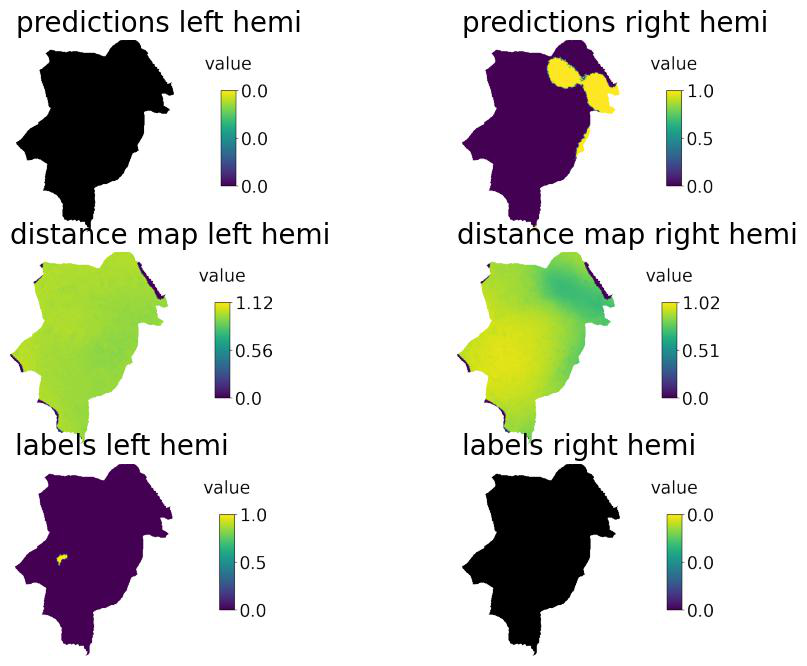

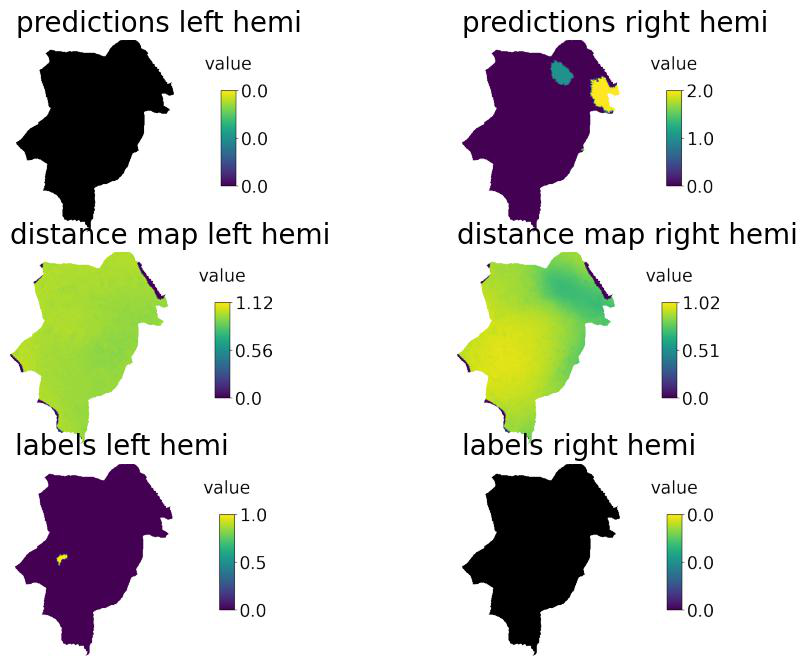

In [27]:
from IPython.display import display
from PIL import Image

subject = 'MELD_H2_3T_FCD_0017'
path="/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all/results_best_model/images"
image = os.path.join(path, subject+'.jpg' )
display(Image.open(image))

# path="/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all_test_thresholds/results_best_model_margin0.2/images"
# image = os.path.join(path, subject+'.jpg' )
# display(Image.open(image))

# path="/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all_test_thresholds/results_best_model_margin0.3/images"
# image = os.path.join(path, subject+'.jpg' )
# display(Image.open(image))

path="/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all_newthreshold/results_best_model/images"
image = os.path.join(path, subject+'.jpg' )
display(Image.open(image))

## compare models performances with stats

0.77 0.47 0.46
0.72 0.56 0.76
0.084 0.042 0.0


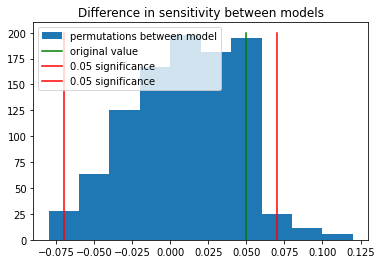

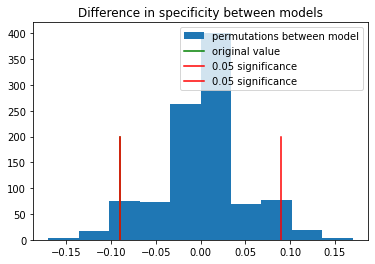

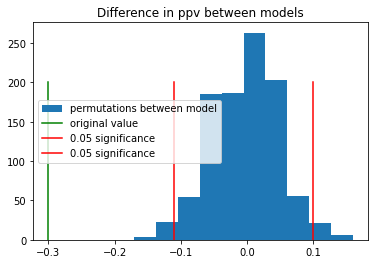

In [26]:
# Compare models with permutation
def permute_models(df):
    for index, row in df.iterrows():
        # Randomly permute the data from column 0 and 1
        permuted_indices = np.random.permutation(2)
        if (permuted_indices == [1,0]).all():
            df.at[index, 'detected_MLP'], df.at[index, 'detected_Graph'] = \
            row[['detected_MLP', 'detected_Graph']].values[permuted_indices]
            df.at[index, 'number TP clusters_MLP'], df.at[index, 'number TP clusters_Graph'] = \
            row[['number TP clusters_MLP', 'number TP clusters_Graph']].values[permuted_indices]
            df.at[index, 'number FP clusters_MLP'], df.at[index, 'number FP clusters_Graph'] = \
            row[['number FP clusters_MLP', 'number FP clusters_Graph']].values[permuted_indices]
    return df


sensitivity_mlp_orig, specificity_mlp_orig, ppv_mlp_orig = df_stats(df_mlp, metrics=['sensitivity', 'specificity', 'ppv'])
print(sensitivity_mlp_orig, specificity_mlp_orig, ppv_mlp_orig)
sensitivity_graph_orig, specificity_graph_orig, ppv_graph_orig = df_stats(df_graph,  metrics=['sensitivity', 'specificity', 'ppv'])
print(sensitivity_graph_orig, specificity_graph_orig, ppv_graph_orig)
#compute difference
diff_sensitivity_orig = sensitivity_mlp_orig - sensitivity_graph_orig
diff_specificity_orig = specificity_mlp_orig - specificity_graph_orig
diff_ppv_orig = ppv_mlp_orig - ppv_graph_orig

#combine results for MLP and Graph 
df_comp = df_mlp[['ID','group','detected','number TP clusters','number FP clusters']].merge(df_graph[['ID','group','detected','number TP clusters','number FP clusters']], how='left', on=['ID','group'], suffixes=['_MLP','_Graph'])

diffs_sensitivity = []
diffs_specificity = []
diffs_ppv = []
for i in range(0,1000):
    # shuffle models
    df_shuffle = permute_models(df_comp.copy())
    
    # compute metrics again
    df_shuffle_mlp = pd.DataFrame()
    df_shuffle_mlp[['group','detected','number TP clusters','number FP clusters']] = df_shuffle[['group','detected_MLP','number TP clusters_MLP','number FP clusters_MLP']].copy()
    sensitivity_mlp_i, specificity_mlp_i, ppv_mlp_i = df_stats(df_shuffle_mlp, metrics=['sensitivity', 'specificity', 'ppv'])
    
    df_shuffle_graph = pd.DataFrame()
    df_shuffle_graph[['group','detected','number TP clusters','number FP clusters']] = df_shuffle[['group','detected_Graph','number TP clusters_Graph','number FP clusters_Graph']].copy()
    sensitivity_graph_i, specificity_graph_i, ppv_graph_i= df_stats(df_shuffle_graph, metrics=['sensitivity', 'specificity', 'ppv'])
    
    # find differences
    diffs_sensitivity.append(sensitivity_mlp_i - sensitivity_graph_i)
    diffs_specificity.append(specificity_mlp_i - specificity_graph_i)
    diffs_ppv.append(ppv_mlp_i - ppv_graph_i)

#compute pvalue
p_sensitivity = get_pvalue(diff_sensitivity_orig, diffs_sensitivity)
p_specificity = get_pvalue(diff_specificity_orig, diffs_specificity)
p_ppv = get_pvalue(diff_ppv_orig, diffs_ppv)
print(p_sensitivity, p_specificity, p_ppv)

#plot results shuffle
plt.figure()
plt.hist(diffs_sensitivity, label='permutations between model')
#add results orig
plt.plot([diff_sensitivity_orig,diff_sensitivity_orig], [0,200], label='original value', color='green')
#add 5% significance lines
lines5 = np.percentile(diffs_sensitivity, [2.5, 97.5])
plt.plot([lines5[0],lines5[0]], [0,200], label='0.05 significance', color='red')
plt.plot([lines5[1],lines5[1]], [0,200], label='0.05 significance', color='red')
plt.title('Difference in sensitivity between models')
plt.legend()

plt.figure()
plt.hist(diffs_specificity, label='permutations between model')
#add results orig
plt.plot([diff_specificity_orig,diff_specificity_orig], [0,200], label='original value', color='green')
#add 5% significance lines
lines5 = np.percentile(diffs_specificity, [2.5, 97.5])
plt.plot([lines5[0],lines5[0]], [0,200], label='0.05 significance', color='red')
plt.plot([lines5[1],lines5[1]], [0,200], label='0.05 significance', color='red')
plt.title('Difference in specificity between models')
plt.legend()

plt.figure()
plt.hist(diffs_ppv, label='permutations between model')
#add results orig
plt.plot([diff_ppv_orig,diff_ppv_orig], [0,200], label='original value', color='green')
#add 5% significance lines
lines5 = np.percentile(diffs_ppv, [2.5, 97.5])
plt.plot([lines5[0],lines5[0]], [0,200], label='0.05 significance', color='red')
plt.plot([lines5[1],lines5[1]], [0,200], label='0.05 significance', color='red')
plt.title('Difference in ppv between models')
plt.legend()



### Compare models IOU on patients detected by both

In [29]:
## compare IOU for patients detected in both model
from functools import partial
df_merge = pd.merge(df_mlp, df_graph, how='inner', on=['ID', 'group'])
df_merge.head()

patients_detected = df_merge[df_merge['group']& df_merge['detected_x']&df_merge['detected_y']]['ID'].values
print(f'number patients detected by both models: {len(patients_detected)} \n')

for (df, model, suffix) in zip([df_mlp,df_graph],['MLP', 'Graph'],['x','y']):
    subdf = df[df['ID'].isin(patients_detected)].copy()
    iou = np.mean(subdf[f'IOU'])
    iou_plus = np.mean(subdf[f'IOU_plus'])
    iou_CI = bootstrap_CI(subdf, func=partial(df_stats, metrics=['IOU', 'IOU+']))
    print('iou')
    print(f'{model} iou: {round(iou,2)} {iou_CI[:,0]}')
    print(f'{model} iou+:  {round(iou_plus,2)} {iou_CI[:,1]}')
    print('\n')
    


number patients detected by both models: 78 

iou
MLP iou: 0.29 [0.25 0.33]
MLP iou+:  0.09 [0.08 0.11]


iou
Graph iou: 0.36 [0.31 0.41]
Graph iou+:  0.25 [0.21 0.28]




0.29
0.36
0.0


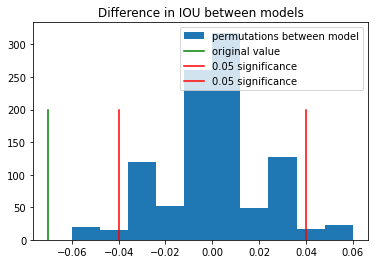

In [30]:
# get the stats

def permute_models_iou(df, metrics=[]):
    for index, row in df.iterrows():
        # Randomly permute the data from column 0 and 1
        permuted_indices = np.random.permutation(2)
        if (permuted_indices == [1,0]).all():
            df.at[index, 'detected_MLP'], df.at[index, 'detected_Graph'] = \
            row[['detected_MLP', 'detected_Graph']].values[permuted_indices]
            df.at[index, 'IOU_MLP'], df.at[index, 'IOU_Graph'] = \
            row[['IOU_MLP', 'IOU_Graph']].values[permuted_indices]
    return df

subdf_mlp = df_mlp[df_mlp['ID'].isin(patients_detected)].copy()
subdf_graph = df_graph[df_graph['ID'].isin(patients_detected)].copy()

iou_mlp_orig = df_stats(subdf_mlp, metrics=['IOU'])[0]
print(iou_mlp_orig)
iou_graph_orig= df_stats(subdf_graph,  metrics=['IOU'])[0]
print(iou_graph_orig)
#compute difference
diff_iou_orig = iou_mlp_orig - iou_graph_orig

#combine results for MLP and Graph 
df_comp = subdf_mlp[['ID','group','detected','IOU']].merge(subdf_graph[['ID','group','detected','IOU']], how='left', on=['ID','group'], suffixes=['_MLP','_Graph'])

diffs_iou = []
for i in range(0,1000):
    # shuffle models
    df_shuffle = permute_models_iou(df_comp.copy())
    
    # compute metrics again
    df_shuffle_mlp = pd.DataFrame()
    df_shuffle_mlp[['group', 'detected','IOU']] = df_shuffle[['group','detected_MLP','IOU_MLP']].copy()
    iou_mlp = df_stats(df_shuffle_mlp, metrics=['IOU'])[0]
    
    df_shuffle_graph = pd.DataFrame()
    df_shuffle_graph[['group','detected','IOU']] = df_shuffle[['group', 'detected_Graph','IOU_Graph']].copy()
    iou_graph= df_stats(df_shuffle_graph, metrics=['IOU'])[0]

    # find differences
    diffs_iou.append(iou_mlp - iou_graph)

#compute pvalue
p_iou = get_pvalue(diff_iou_orig, diffs_iou)
print(p_iou)

#plot results shuffle
plt.figure()
plt.hist(diffs_iou, label='permutations between model')
#add results orig
plt.plot([diff_iou_orig,diff_iou_orig], [0,200], label='original value', color='green')
#add 5% significance lines
lines5 = np.percentile(diffs_iou, [2.5, 97.5])
plt.plot([lines5[0],lines5[0]], [0,200], label='0.05 significance', color='red')
plt.plot([lines5[1],lines5[1]], [0,200], label='0.05 significance', color='red')
plt.title('Difference in IOU between models')
plt.legend()

## plot reduction number of clusters and increase ppv

In [11]:
#number clusters

for (model, df_model) in zip(['MLP','Graph'],[df_mlp,df_graph]):
    print(model)
    for group in [False,True]:
        num_fp = df_model[df_model['group']==group]['number FP clusters'].values
        results = np.quantile(num_fp, [.5,.25,.75,1])
        group_name = 'Patients' if group==True else 'Controls'
        print(f'{group_name} median (IQR), max : {results[0]} ({results[1]}-{results[2]}), {results[3]}')

MLP
Controls median (IQR), max : 1.0 (0.0-1.0), 16.0
Patients median (IQR), max : 1.0 (0.0-2.0), 7.0
Graph
Controls median (IQR), max : 0.0 (0.0-1.0), 2.0
Patients median (IQR), max : 0.0 (0.0-0.0), 3.0


/tmp/ipykernel_2284871/3694068693.py:55: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  axs[i].scatter(x, y, marker='o')


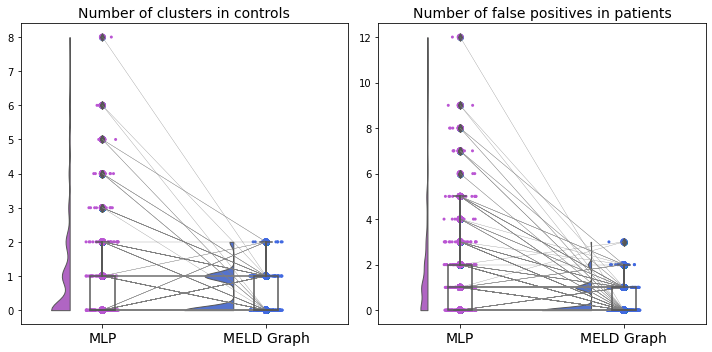

In [57]:
### plot number clusters

## Concat results

df = pd.concat([df_mlp, df_graph], ignore_index=True)
df.head()

import ptitprince as pt
import matplotlib.gridspec as gridspec

def get_connection(df):
    connects=[]
    for subject in np.unique(df['ID']):
        subdf=df[df['ID']==subject]
        connects.append([subdf[subdf['model']=='per vertex'].index[0],
                        subdf[subdf['model']=='graph'].index[0]])
    return connects

def connectpoints(x,y,p1,p2,colors):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.scatter([x1,x2],[y1,y2], c=colors)
    plt.plot([x1,x2],[y1,y2], 'grey', linewidth=0.3)
    

fig = plt.figure(figsize=(10,5))
gs1 = gridspec.GridSpec(1, 2)
axs = []

ort='v'
pal={'per vertex':'mediumorchid', 'graph':'royalblue'}

for i,group in enumerate([False,True]):
    axs.append(fig.add_subplot(gs1[i]))
    subdf=df[df['group']==group]
    subdf.reset_index(drop=True, inplace=True)
    if group == True:
        y_var = 'number FP clusters'
        ax_label = 'Number of false positives in patients'
    else:
        y_var = 'number FP clusters'
        ax_label = 'Number of clusters in controls'
    axs[i]=pt.RainCloud(x='model', y=y_var, palette = pal, data=subdf, bw= .2, cut=0, 
                            scale="area", width_viol=.6, orient=ort, jitter = 0.1, dodge=False)
    # axs[i].set_title('group)
    axs[i].set_title(ax_label, fontsize='14')
    locs, labels = plt.xticks()  # Get the current locations and labels.
    axs[i].set_xticks(locs, labels=['MLP','MELD Graph'], fontsize='14')
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    #plot connections
    connects=get_connection(subdf)
    x=subdf['model'].to_numpy()
    y=subdf['number FP clusters'].to_numpy()
    axs[i].scatter(x, y, marker='o')
    axs[i].set_xlim([-0.5,1.5])
    for connect in connects:
        connectpoints(x,y,connect[0],connect[1], colors = [pal['per vertex'],pal['graph']])
    plt.tight_layout()
    


Text(0, 0.5, 'PPV')

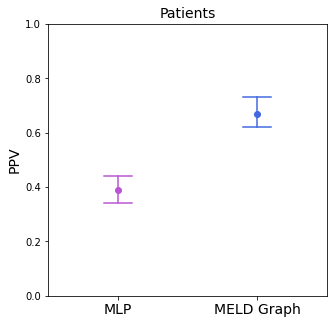

In [62]:
import ptitprince as pt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(5,5))
axs = []

plt.scatter(1,ppv_mlp,color='mediumorchid')
plt.plot((1,1),(CI_mlp[0,2],CI_mlp[1,2]),'-',color='mediumorchid')
plt.plot((1-0.1,1+0.1), (CI_mlp[0,2],CI_mlp[0,2]),'-',color='mediumorchid')
plt.plot((1-0.1,1+0.1),(CI_mlp[1,2],CI_mlp[1,2]),'-',color='mediumorchid')

plt.scatter(2,ppv_graph,color='royalblue')
plt.plot((2,2),(CI_graph[0,2],CI_graph[1,2]),'-',color='royalblue')
plt.plot((2-0.1,2+0.1), (CI_graph[0,2],CI_graph[0,2]),'-',color='royalblue')
plt.plot((2-0.1,2+0.1),(CI_graph[1,2],CI_graph[1,2]),'-',color='royalblue')


plt.title('Patients', fontsize='14')
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks([1,2], labels=['MLP','MELD Graph'], fontsize='14')
plt.xlim([0.5,2.5])
plt.ylim([0,1])
plt.ylabel("PPV", fontsize='14')

## Analyse MELD graph results

### add breakdown on test dataset

In [13]:
#for test dataset
model = '23-10-30_LVHZ_dcp'

dataset = 'test'

cohort, subjects, pred_file = load_cohort_graph(dataset,model,no_combat=False)

In [11]:
df_model = df_graph.copy()

# add demographic
age_array=[]
sex_array=[]
histo_array=[]
site_array=[]
scanner_array=[]
flair_array=[]
group_array=[]
sf_array=[]
mri_negative_array=[]
surgery_array=[]
for subject in df_model['ID']:
    subj = MeldSubject(subject, cohort)
    age, sex, histo, site, sf, mri_negative, surgery = subj.get_demographic_features(["Age at preoperative", "Sex", "Histology", "Site", "Seizure free", "Ever reported MRI negative", "Surgery"])
    scanner_array.append(subj.scanner)
    age_array.append(age)
    sex_array.append(sex)
    histo_array.append(histo)
    site_array.append(site)
    sf_array.append(sf)
    flair_array.append(subj.has_flair)
    mri_negative_array.append(mri_negative)
    surgery_array.append(surgery)

    
df_model['Age at preoperative']=age_array
df_model['Sex']=sex_array
df_model['Histology']=histo_array
df_model['Site']=site_array
df_model['Scanner']=scanner_array
df_model['FLAIR']=flair_array
df_model['Seizure free']=sf_array
df_model['Ever reported MRI negative'] = mri_negative_array
df_model['Operated'] = surgery_array

df_model.head()

,index,ID,group,model,max_pred,size_cluster,detected,number TP clusters,size_pred,IOU,...,number FP clusters,Age at preoperative,Sex,Histology,Site,Scanner,FLAIR,Seizure free,Ever reported MRI negative,Operated
0,0,MELD2_H7_3T_FCD_001,True,graph,0.108008,8289,True,1,19448.0,0.052029,...,2,10.0,1.0,FCD_1,H7,3T,True,1.0,0.0,1.0
1,0,MELD2_H7_3T_FCD_004,True,graph,0.247082,8865,True,1,12981.0,0.352755,...,1,12.0,1.0,FCD_1,H7,3T,True,1.0,0.0,1.0
2,0,MELD2_H7_3T_FCD_005,True,graph,0.931053,1639,False,0,13212.0,0.000000,...,1,17.0,0.0,FCD_2B,H7,3T,True,0.0,0.0,1.0
3,0,MELD2_H7_3T_FCD_009,True,graph,0.892672,3186,True,1,31015.0,0.215455,...,0,7.0,1.0,FCD_1,H7,3T,True,1.0,0.0,1.0
4,0,MELD_H10_3T_C_0005,False,graph,0.002829,0,NaN,0,NaN,NaN,...,0,16.0,0.0,NaN,H10,3T,False,NaN,NaN,NaN


In [28]:
pat = df_model[df_model['group']==True].copy()

pat.detected = pat.detected.astype(int)

In [15]:
def compute_pval(df_var,diff_orig, var='Seizure free'):
    diffs = []
    for i in range(0,1000):
        df_shuffle = df_var.copy()
        np.random.shuffle(df_shuffle[var].values)
        disp_df_shuffle=pd.DataFrame(100*df_shuffle.groupby([var]).mean()['detected']).round(1)
        diffs.append(disp_df_shuffle['detected'].values[1]-disp_df_shuffle['detected'].values[0])

    pval = get_pvalue(diff_orig, diffs)
    print(pval)
    
    #plot results shuffle
    plt.figure()
    plt.hist(diffs, label='permutations between group')
    #add results orig
    plt.plot([diff_orig,diff_orig], [0,200], label='original value', color='green')
    #add 5% significance lines
    lines5 = np.percentile(diffs, [2.5, 97.5])
    plt.plot([lines5[0],lines5[0]], [0,200], label='0.05 significance', color='red')
    plt.plot([lines5[1],lines5[1]], [0,200], label='0.05 significance', color='red')
    plt.title(f'Difference between group {var}')
    plt.legend()
    
    return pval

In [29]:
disp_df=pd.DataFrame(100*pat.groupby('Scanner').mean()['detected']).round(1)
disp_df['count'] = pat.groupby('Scanner').count()['detected']
disp_df

,detected,count
Scanner,,
15T,60.7,56
3T,72.1,204


In [30]:
disp_df=pd.DataFrame(100*pat.groupby(['Scanner','FLAIR']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['Scanner','FLAIR']).count()['detected']
disp_df

detected  count
Scanner FLAIR                 
15T     False      55.6     36
        True       70.0     20
3T      False      71.1    114
        True       73.3     90

0.382
-5.400000000000006 0.382


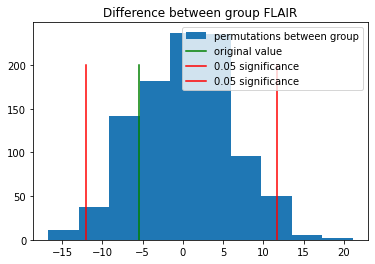

In [35]:
disp_df=pd.DataFrame(100*pat.groupby(['FLAIR']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['FLAIR']).count()['detected']
disp_df

#get difference and pval
diff_orig = disp_df['detected'].values[0]-disp_df['detected'].values[1]
var='FLAIR'
pval= compute_pval(pat[['detected',var]], diff_orig, var=var)
print(diff_orig, pval)


              detected  count
Seizure free                 
0.0               62.7     51
1.0               79.2    106
0.034
-16.5 0.034


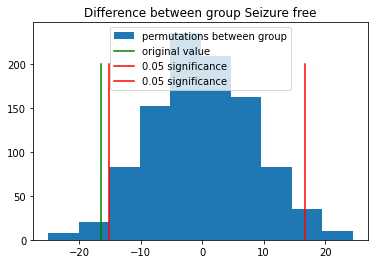

In [34]:
disp_df=pd.DataFrame(100*pat.groupby(['Seizure free']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['Seizure free']).count()['detected']
print(disp_df)

#get difference and pval
diff_orig = disp_df['detected'].values[0]-disp_df['detected'].values[1]
var='Seizure free'
pval= compute_pval(pat[['detected',var]], diff_orig, var=var)
print(diff_orig, pval)


     detected  count
Sex                 
0.0      62.4    125
1.0      76.3    135
0.016
-13.899999999999999 0.016


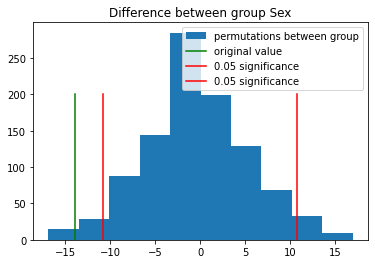

In [36]:
disp_df=pd.DataFrame(100*pat.groupby(['Sex']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['Sex']).count()['detected']
print(disp_df)

#get difference and pval
diff_orig = disp_df['detected'].values[0]-disp_df['detected'].values[1]
var='Sex'
pval= compute_pval(pat[['detected',var]], diff_orig, var=var)
print(diff_orig, pval)

In [38]:
pat['Operated'] = pat['Operated'].fillna(666)
pat['Histology'] = pat['Histology'].fillna('not available')
pat.loc[(pat['Histology']=='not available')&(pat['Operated']==0), 'Histology'] = 'not operated'
disp_df=pd.DataFrame(100*pat.groupby(['Histology']).mean()['detected']).round(1)
disp_df['n patients'] = pat.groupby(['Histology']).count()['detected']
disp_df['n patients detected'] = pat.groupby(['Histology']).sum()['detected']
print(disp_df.rename(columns={'detected':'% Detected'}))

#get difference and pval
var='Histology'
histos = ['FCD_1', 'FCD_2A', 'FCD_2B', 'FCD_3', 'not available', 'not operated']
diff_orig_histos = np.zeros(len(histos))
for h,histo in enumerate(histos):
    diff_orig_histos[h]=disp_df['detected'].values[h]

diffs_histos = np.zeros((len(histos), 1000))
for i in range(0,1000):
    df_shuffle = pat[['detected',var]].copy()
    np.random.shuffle(df_shuffle[var].values)
    for h,histo in enumerate(histos):
        disp_df_shuffle=pd.DataFrame(100*df_shuffle.groupby([var]).mean()['detected']).round(1)
        diffs_histos[h,i] = disp_df_shuffle['detected'].values[h]
pvals_histos= np.zeros(len(histos))
for h,histo in enumerate(histos):
    pval = get_pvalue(diff_orig_histos[h], diffs_histos[h,:])
    print(histo)
    print(pval)
    pvals_histos[h]=pval
    
import statsmodels.stats.multitest as multi
pvals_histos_cor = multi.multipletests(pvals_histos.flatten(), alpha=0.05, method='holm')[1]
print(pvals_histos_cor)

               % Detected  n patients  n patients detect
Histology                                               
FCD_1                84.6          13                 11
FCD_2A               75.4          57                 43
FCD_2B               76.3          93                 71
FCD_3                75.0           8                  6
not available        47.8          23                 11
not operated         59.1          66                 39
FCD_1
0.104
FCD_2A
0.194
FCD_2B
0.074
FCD_3
0.542
not available
0.01
not operated
0.024
[0.312 0.388 0.296 0.542 0.06  0.12 ]


                            detected  count
Ever reported MRI negative                 
0.0                             72.2    180
1.0                             63.7     80
0.178
8.5 0.178


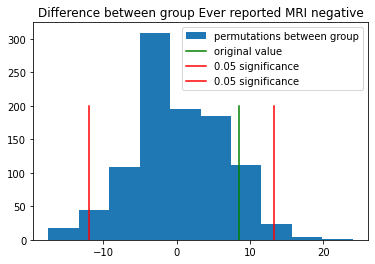

In [39]:
disp_df=pd.DataFrame(100*pat.groupby(['Ever reported MRI negative']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['Ever reported MRI negative']).count()['detected']
print(disp_df)

#get difference and pval
diff_orig = disp_df['detected'].values[0]-disp_df['detected'].values[1]
var='Ever reported MRI negative'
pval= compute_pval(pat[['detected',var]], diff_orig, var=var)
print(diff_orig, pval)

            detected  count
paediatric                 
False           67.9    131
True            71.3    129
0.532
-3.3999999999999915 0.532


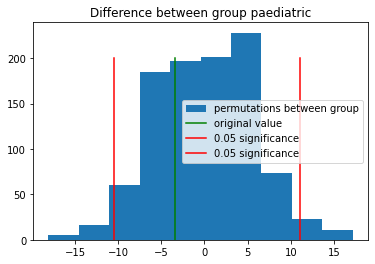

In [40]:
pat['paediatric'] = pat['Age at preoperative']<18
disp_df=pd.DataFrame(100*pat.groupby(['paediatric']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['paediatric']).count()['detected']
print(disp_df)

#get difference and pval
diff_orig = disp_df['detected'].values[0]-disp_df['detected'].values[1]
var='paediatric'
pval= compute_pval(pat[['detected',var]], diff_orig, var=var)
print(diff_orig, pval)

            detected  count
SF_&_histo                 
False           62.3    162
True            81.6     98
0.0
-19.299999999999997 0.0


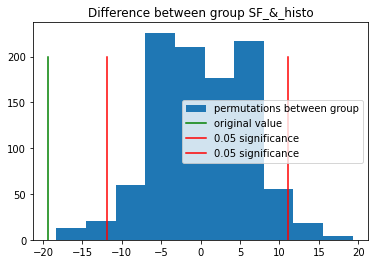

In [41]:
# FCD histology + SF
pat['Histology'] = pat['Histology'].fillna('not available')
pat['Histology_confirmed']= pat['Histology']!='not available'

pat['SF_&_histo'] = pat['Histology_confirmed'] & pat['Seizure free']

disp_df=pd.DataFrame(100*pat.groupby(['SF_&_histo']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['SF_&_histo']).count()['detected']
print(disp_df)

#get difference and pval
diff_orig = disp_df['detected'].values[0]-disp_df['detected'].values[1]
var='SF_&_histo'
pval= compute_pval(pat[['detected',var]], diff_orig, var=var)
print(diff_orig, pval)

In [42]:
# number of MRI negative & Histo confirm

print(pat.groupby(['Ever reported MRI negative', 'Histology'])['ID'].count())

pat['Histology'] = pat['Histology'].fillna('not available')
pat['Histology_confirmed']= pat['Histology']!='not available'
pat['MRIneg_&_histo'] = pat['Histology_confirmed'] & pat['Ever reported MRI negative']

print(pat.groupby(['Ever reported MRI negative', 'Histology_confirmed'])['ID'].count())

disp_df=pd.DataFrame(100*pat.groupby(['Ever reported MRI negative','Histology_confirmed']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['Ever reported MRI negative','Histology_confirmed']).count()['detected']
print(disp_df)

Ever reported MRI negative  Histology    
0.0                         FCD_1             5
                            FCD_2A           33
                            FCD_2B           69
                            FCD_3             6
                            not available    12
                            not operated     55
1.0                         FCD_1             8
                            FCD_2A           24
                            FCD_2B           24
                            FCD_3             2
                            not available    11
                            not operated     11
Name: ID, dtype: int64
Ever reported MRI negative  Histology_confirmed
0.0                         False                   12
                            True                   168
1.0                         False                   11
                            True                    69
Name: ID, dtype: int64
                                                detected  count
Ever